In [2]:
pip install pmdarima

DEPRECATION: Loading egg at /Users/Yatharth/anaconda3/lib/python3.11/site-packages/py_ecg_detectors-1.3.5-py3.11.egg is deprecated. pip 24.3 will enforce this behaviour change. A possible replacement is to use pip for package installation.. Discussion can be found at https://github.com/pypa/pip/issues/12330
DEPRECATION: Loading egg at /Users/Yatharth/anaconda3/lib/python3.11/site-packages/deep_xf-0.0.5-py3.11.egg is deprecated. pip 24.3 will enforce this behaviour change. A possible replacement is to use pip for package installation.. Discussion can be found at https://github.com/pypa/pip/issues/12330
DEPRECATION: Loading egg at /Users/Yatharth/anaconda3/lib/python3.11/site-packages/plotly-5.10.0-py3.11.egg is deprecated. pip 24.3 will enforce this behaviour change. A possible replacement is to use pip for package installation.. Discussion can be found at https://github.com/pypa/pip/issues/12330
  Using cached Cython-3.0.10-py2.py3-none-any.whl.metadata (3.2 kB)
   ━━━━━━━━━━━━━━━━━━━━

In [2]:
# library imports
import numpy as np
import pandas as pd
import pmdarima as pm

# just for jupyter notebooks plot size
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [15, 10]

# Data set up

In [5]:
# data read
data = pd.read_csv("/Users/Yatharth/Desktop/dc/data/data_tf.csv", parse_dates=["date"])
metadata = pd.read_csv("/Users/Yatharth/Desktop/dc/data/meta_data.csv")

# target variable = GDP
target_variable = "gdpc1"
target_lag = 1 # GDP published after completion of the next month

# which artificial lags to test the model on, equivalent to number of months ahead of and behind the target date (e.g. 2020-06-01 for Q2 2020)
lags = list(range(-2, 3))

# train and test dates
train_start_date = "1947-01-01"
test_start_date = "2005-03-01"
test_end_date = "2010-03-01"

# train and test datasets
test = data.loc[(data.date >= train_start_date) & (data.date <= test_end_date), :].reset_index(drop=True)

Data should be a dataframe of seasonally adjusted growth rates with months in rows and quarterly variables in the last month of the quarter, with `np.nan`s for interquarter months.

In [9]:
data.tail(20)

,date,payems,gdpc1,cpiaucsl,dgorder,hsn1f,rsafs,unrate,houst,indpro,...,ir,cpilfesl,pcepilfe,pcepi,permit,tcu,businv,ulcnfb,iq,a261rx1q020sbea
893,2021-06-01,0.003838,0.017070,0.008771,0.017723,-0.035135,0.009568,0.017241,0.036760,0.004147,...,0.010542,0.008005,0.004812,0.005565,-0.017741,0.005160,0.009171,0.011124,0.011511,0.007584
894,2021-07-01,0.004729,NaN,0.004536,0.003722,0.016807,-0.015690,-0.084746,-0.054688,0.006788,...,0.002981,0.003138,0.003937,0.004573,-0.003612,0.007405,0.006892,NaN,0.010669,NaN
895,2021-08-01,0.003532,NaN,0.003336,0.015547,-0.055096,0.009610,-0.037037,0.001907,-0.000351,...,-0.002229,0.001836,0.003293,0.003949,0.070695,-0.000142,0.009065,NaN,0.002111,NaN
896,2021-09-01,0.002886,0.006567,0.004109,-0.014878,0.067055,0.010561,-0.096154,-0.010787,-0.009790,...,0.004468,0.002546,0.002090,0.003126,-0.088600,-0.009962,0.008520,0.022531,0.002809,0.011210
897,2021-10-01,0.004595,NaN,0.008665,0.014803,-0.083333,0.014189,-0.021277,0.002566,0.015127,...,0.014826,0.006028,0.004078,0.005744,0.051393,0.014610,0.012523,NaN,0.018908,NaN
898,2021-11-01,0.004371,NaN,0.006992,0.014255,0.126677,0.010916,-0.086957,0.091491,0.005927,...,0.007305,0.005232,0.005163,0.006137,0.018257,0.005121,0.014142,NaN,0.006873,NaN
899,2021-12-01,0.003956,0.016957,0.005752,0.009407,0.109788,-0.020267,-0.071429,0.036342,-0.001984,...,-0.003626,0.005618,0.005437,0.005423,0.096588,-0.003029,0.022765,0.008930,-0.015700,0.016382
900,2022-01-01,0.003377,NaN,0.006451,0.030772,-0.009535,0.027056,0.025641,-0.057692,0.003806,...,0.019651,0.005833,0.004726,0.005284,-0.029008,0.002546,0.012305,NaN,0.027739,NaN
901,2022-02-01,0.004768,NaN,0.007977,-0.007044,-0.049338,0.016520,-0.050000,0.066627,0.007369,...,0.017844,0.005052,0.003677,0.005935,0.008691,0.005984,0.017391,NaN,0.032389,NaN
902,2022-03-01,0.002645,-0.004103,0.012408,0.006720,-0.105063,0.011531,-0.052632,-0.034328,0.006540,...,0.029453,0.003241,0.003680,0.009511,0.011847,0.005048,0.023936,0.020678,0.039216,0.001937


# Training the model

In [21]:
# training ARMA model for order
train_series = test.loc[(~pd.isna(test[target_variable])) & (test.date < test_start_date), target_variable].reset_index(drop=True) # only the target series is used in the ARMA model
model = pm.auto_arima(train_series, seasonal=False, stationary=True)
ar_order = model.order[0]
ma_order = model.order[2]

# Testing the model on artificial data vintages

In [22]:
# dates in the test set
dates = (
        pd.date_range(test_start_date, test_end_date, freq="3MS")
        .strftime("%Y-%m-%d")
        .tolist()
    )

# actual values
actuals = list(test.loc[test.date.isin(dates), target_variable].values)

/var/folders/t5/x6j52_gn3k3cr27dn63vlslr0000gn/T/ipykernel_14228/3097558002.py:9: FutureWarning: The behavior of 'isin' with dtype=datetime64[ns] and castable values (e.g. strings) is deprecated. In a future version, these will not be considered matching by isin. Explicitly cast to the appropriate dtype before calling isin instead.
  actuals = list(test.loc[test.date.isin(dates), target_variable].values)


In [26]:
import pandas as pd
import numpy as np
import pmdarima as pm

# Assuming you have defined lags, dates, test, target_variable, ar_order, ma_order, and target_lag

# Initialize prediction dictionary
pred_dict = {k: [] for k in lags}

# Suppress convergence warnings
import warnings
from statsmodels.tools.sm_exceptions import ConvergenceWarning
warnings.simplefilter('ignore', ConvergenceWarning)

for lag in lags:
    for date in dates:
        test_series = test.loc[test.date <= date, ["date", target_variable]]
        test_series.iloc[len(test_series)+lag-1-target_lag:, 1] = np.nan  # Simulated vintage
        
        # Ensure target variable isn't given
        test_series.loc[test_series.date == date, target_variable] = np.nan
        
        ts = test_series.loc[~pd.isna(test_series[target_variable])].reset_index(drop=True)
        ts_dates = ts.date
        ts_series = ts[target_variable]

        # Fit ARIMA model with increased maxiter
        ts_model = pm.arima.ARIMA((ar_order, 0, ma_order), maxiter=1000)
        preds = ts_model.fit_predict(ts_series)

        # Make sure getting the right date for prediction
        final_dates = pd.date_range(ts_dates[0], periods=len(ts_dates)+10, freq="3MS")
        final_preds = list(ts_series) + list(preds)
        final = pd.DataFrame({"date": final_dates, "preds": final_preds})
        pred = final.loc[final.date == date, "preds"].values[0]
        
        pred_dict[lag].append(pred)


# Assess and visualize model performance

In [27]:
# table of RMSE by vintage
performance = pd.DataFrame(columns=["Vintage", "RMSE"])
for lag in lags:
    tmp = pd.DataFrame({
        "Vintage":lag,
        "RMSE":np.sqrt(np.mean((np.array(actuals) - np.array(pred_dict[lag])) ** 2))
    }, index=[0])
    performance = pd.concat([performance, tmp]).reset_index(drop=True)
performance.round(4)

/var/folders/t5/x6j52_gn3k3cr27dn63vlslr0000gn/T/ipykernel_14228/687125535.py:8: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  performance = pd.concat([performance, tmp]).reset_index(drop=True)


,Vintage,RMSE
0,-2,0.0091
1,-1,0.0079
2,0,0.0079
3,1,0.0079
4,2,0.0079


''

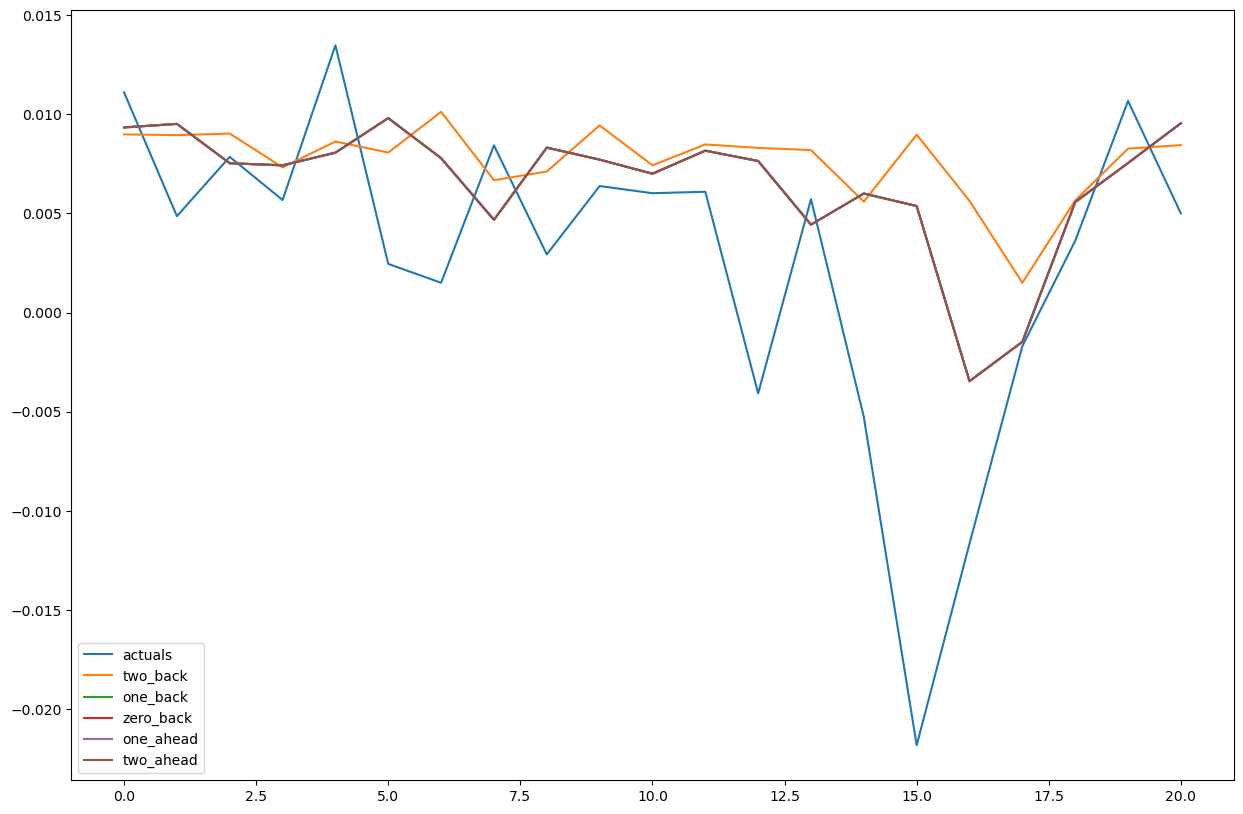

In [28]:
# plot of predictions vs actuals
pd.DataFrame({
    "actuals":actuals, 
    "two_back":pred_dict[-2], 
    "one_back":pred_dict[-1], 
    "zero_back":pred_dict[0],
    "one_ahead":pred_dict[1],
    "two_ahead":pred_dict[2]}
).plot()
;

# Final model usage / getting predictions on new data
Say model selection is finished and the model is to now be used, i.e. used to get predictions on new data.

In [29]:
# the test data ends 2010-03-01, let's say we wanted to predict 2010-06-01
new_data = test.copy()
ts_series = new_data.loc[~pd.isna(new_data[target_variable]), target_variable]
ts_model = pm.arima.ARIMA((ar_order, 0, ma_order))
preds = ts_model.fit_predict(ts_series, n_periods=10) # n_periods is how many periods ahead to generate predictions

/Users/Yatharth/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/Yatharth/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/Yatharth/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


In [30]:
preds.iloc[0]

0.007997893224616689